# SparseEdges : computing sparseness of natural images with retina-like RFs

Let's compute the "edges" produced with symmetrical filters.

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cluster = False

In [3]:
from __future__ import division, print_function
import matplotlib
pylab_defaults = { 
    'font.size': 10,
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'text.usetex': False,
    'font.family' : 'sans-serif',
    'font.sans-serif' : ['Helvetica'],
    }
matplotlib.rcParams.update(pylab_defaults)

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import os
import numpy as np
np.set_printoptions(precision=2, suppress=True)
fig_width_pt = 397.48  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches
#fig_width = 21
figsize=(fig_width, .618*fig_width)

In [4]:
%cd ../test
figpath, ext = os.path.join(os.getenv('HOME'), 'pool/science/RetinaClouds/2016-05-20_nips'), '.pdf'
exp='retina_sparseness'

/Users/laurentperrinet/pool/science/BICV/SparseEdges/test


defining framework


In [62]:
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.N_X, mp.N_Y = 64, 64
mp.init()
print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.62  0.38  0.24  0.15  0.09  0.06  0.03  0.02]


Standard edges are oriented, but one may modify that:

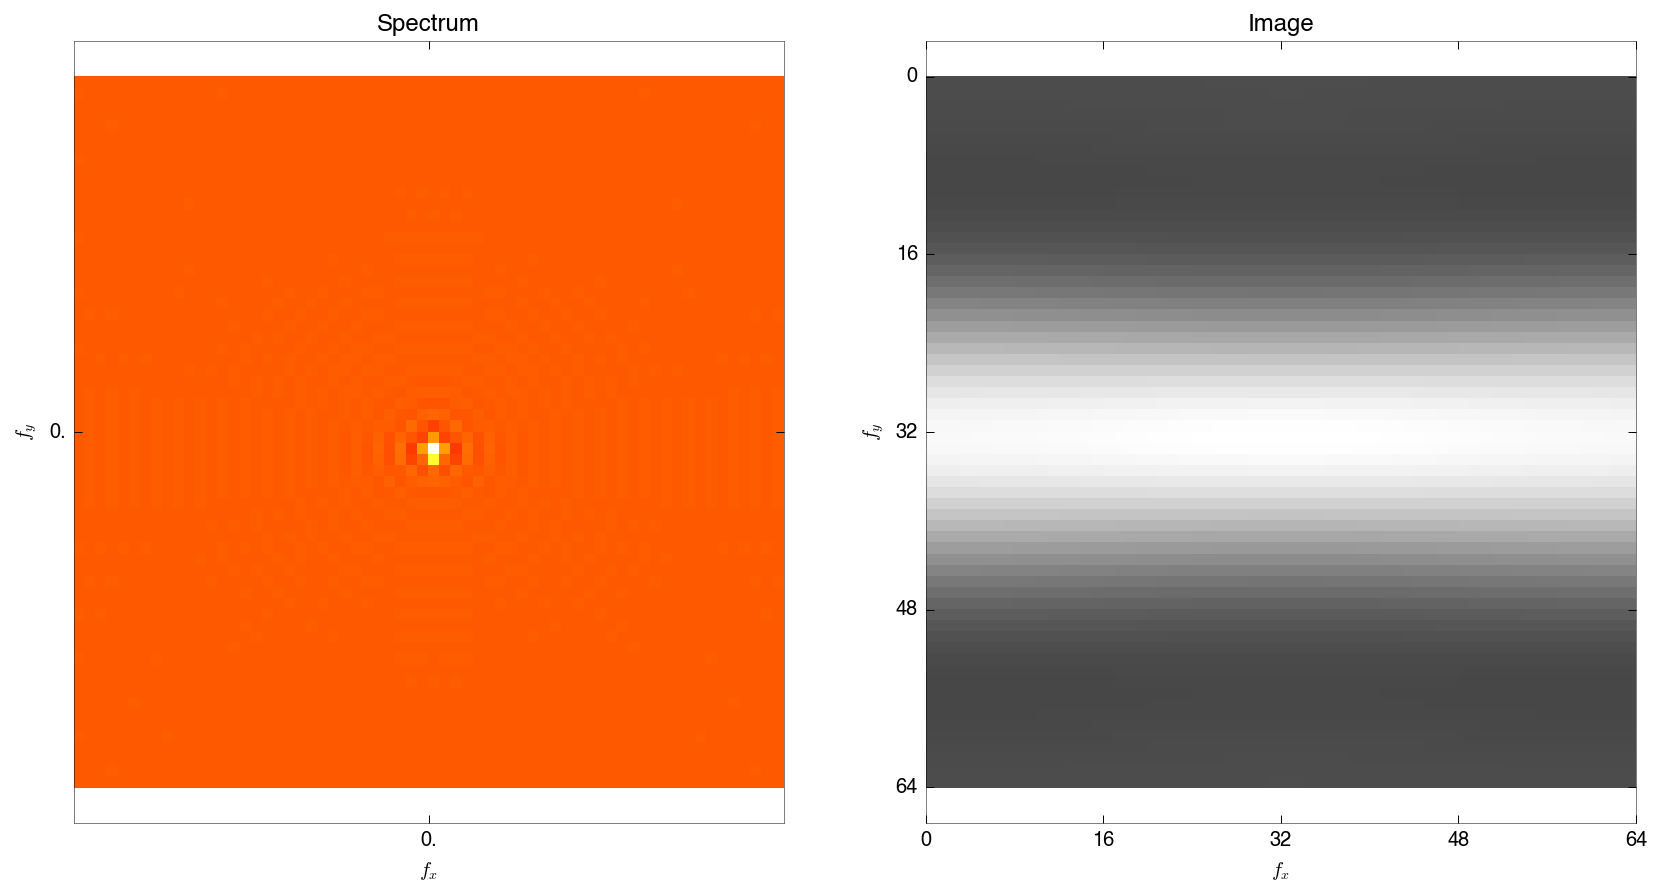

In [63]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': mp.pe.B_sf, 'theta':0., 'B_theta': mp.pe.B_theta}
FT_lg = mp.loggabor(mp.N_X/2, mp.N_Y/2, **params)
#(fourier_domain(mp.normalize(np.absolute(FT_lg), center=False))+ image_domain(mp.normalize(mp.invert(FT_lg), center=False)))
fig, a1, a2 = mp.show_FT(FT_lg, axis=True, figsize=(fig_width, fig_width/2))
fig.tight_layout()
fig.savefig(os.path.join(figpath, exp + '_loggabor' + ext))

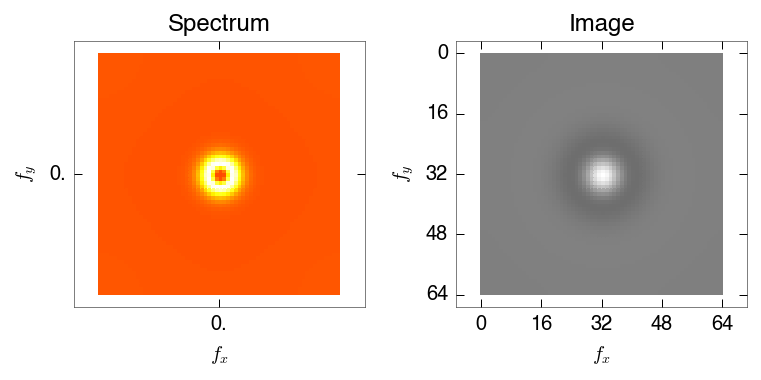

In [65]:
sf_0 = .06 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': mp.pe.B_sf, 'theta':0., 'B_theta': np.inf}
FT_lg = mp.loggabor(mp.N_X/2, mp.N_Y/2, **params)
fig, a1, a2 = mp.show_FT(FT_lg, axis=True, figsize=(fig_width, fig_width/2))
fig.tight_layout()
fig.savefig(os.path.join(figpath, exp + '_dog' + ext))

When defining the framework, one thus needs only one angle:

In [8]:
print ('Range of angles: ', mp.theta*180./np.pi)
mp.pe.n_theta = 1
mp.pe.B_theta = np.inf
mp.init()
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
Range of angles:  [ 90.]


In [9]:
print('Final sparseness in the pyramid = {}'.format(mp.pe.N/(4/3*mp.N_X*mp.N_Y)))

Final sparseness in the pyramid = 0.0234375


## one example image

-0.950759120364 0.891900615494


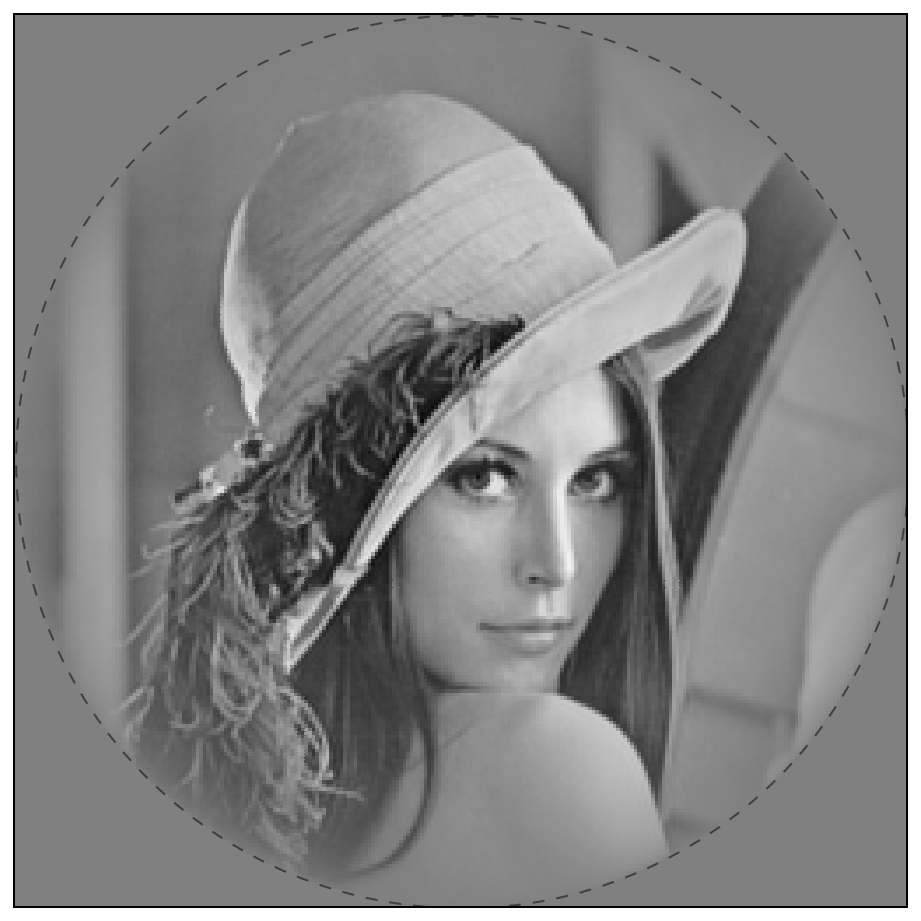

In [10]:
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
image = mp.imread('https://raw.githubusercontent.com/meduz/SparseEdges/master/database/lena256.png')
mp.pe.mask_exponent = 4.
mp.init()
image = mp.normalize(image, center=False)
image *= mp.mask
print(image.min(), image.max())
fig, ax = mp.imshow(image, mask=True, norm=False)


In [11]:
mp.pe.N = 2**12
name = exp.replace('_sparseness', '_lena')
matname = os.path.join(mp.pe.matpath, name + '.npy')
try:
    edges = np.load(matname)
except:
    edges, C_res = mp.run_mp(image, verbose=False)
    np.save(matname, edges)    

image_rec = mp.reconstruct(edges, mask=True)        

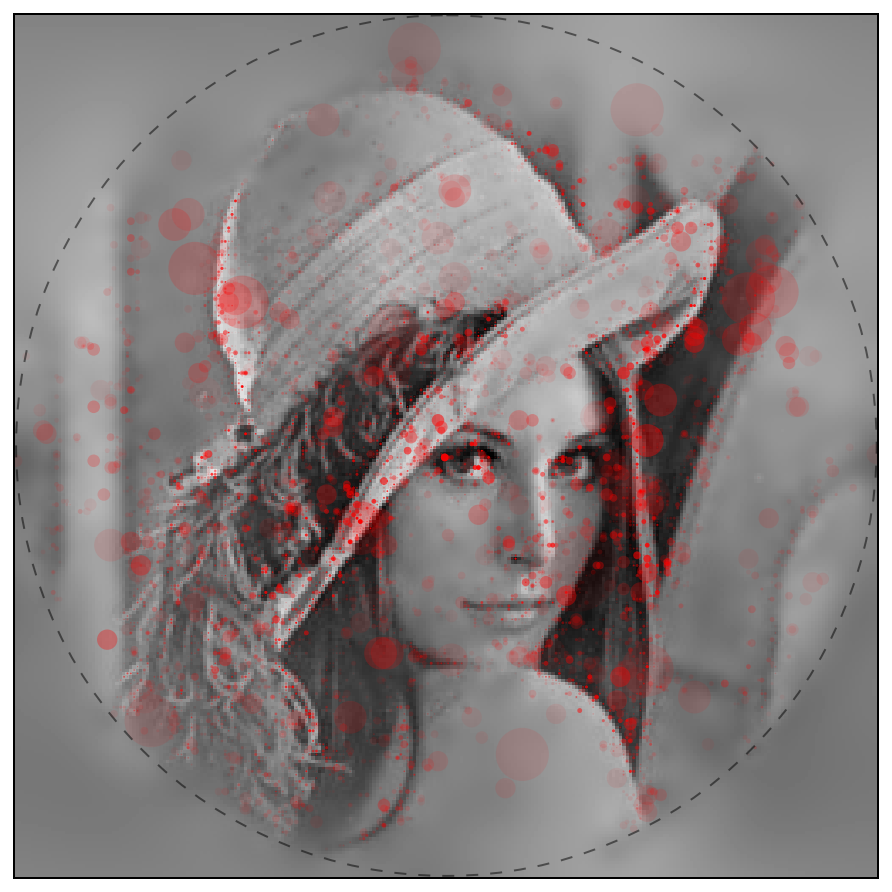

In [12]:
mp.pe.line_width = 0
fig, a = mp.show_edges(edges, image=mp.dewhitening(image_rec), show_phase=False, mask=True)
fig.savefig(os.path.join(figpath, name + ext))

In [13]:
import numpy as np
for i in range(12,13): print(np.logspace(0, 11, i, base=2))

[    1.     2.     4.     8.    16.    32.    64.   128.   256.   512.
  1024.  2048.]


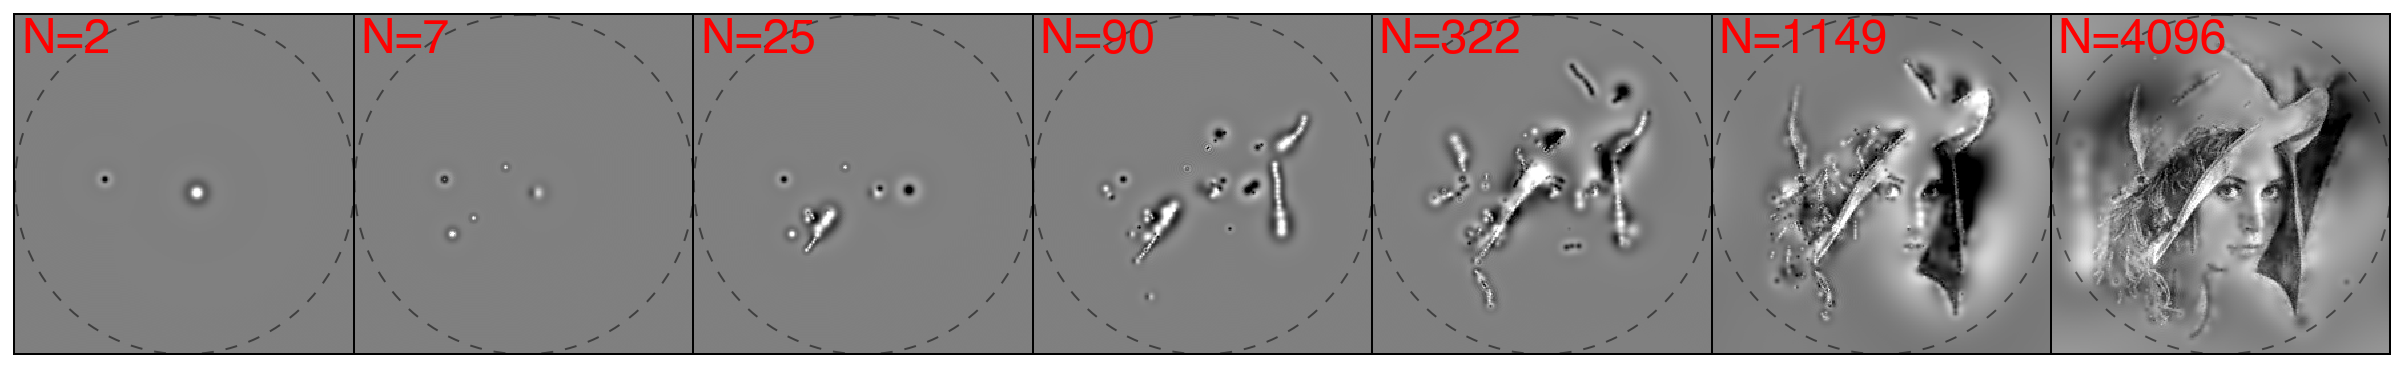

In [14]:
list_of_number_of_edge = np.logspace(0, 11, 7, base=2)*2
fig, axs = plt.subplots(1, len(list_of_number_of_edge), figsize=(3*fig_width, 3*fig_width/len(list_of_number_of_edge)))
vmax = 1.
image_rec = mp.reconstruct(edges, mask=True)        
vmax = mp.dewhitening(image_rec).max()
for i_ax, number_of_edge in enumerate(list_of_number_of_edge):
    edges_ = edges[:, :number_of_edge][..., np.newaxis]
    image_rec = mp.dewhitening(mp.reconstruct(edges_, mask=True))
    fig, axs[i_ax] = mp.imshow(image_rec/vmax, fig=fig, ax=axs[i_ax], norm=False, mask=True)
    axs[i_ax].text(5, 29, 'N=%d' % number_of_edge, color='red', fontsize=24)
plt.tight_layout()
fig.subplots_adjust(hspace = .0, wspace = .0, left=0.0, bottom=0., right=1., top=1.)

if not(figpath==''): 
    fig.savefig(os.path.join(figpath, name + '_movie' + ext))

## Running simulations on a set of natural images

In [15]:
%%writefile ../test/experiment_retina_sparseness.py
# -*- coding: utf8 -*-
from __future__ import division, print_function
"""

$ python experiment_retina_sparseness.py

rm -fr **/retina_sparseness* **/**/retina_sparseness*

"""
import numpy as np
from SparseEdges import SparseEdges
mps = []
for name_database in ['serre07_distractors']:#, 'serre07_distractors_urban', 'laboratory']:
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.datapath = '../../SLIP/database/'
    mp.pe.N_image = 100
    mp.pe.do_mask = True
    mp.pe.N = 2**12
    mp.pe.n_theta = 1
    mp.pe.B_theta = np.inf
    mp.pe.line_width = 0
    mp.init()
    # normal experiment
    imageslist, edgeslist, RMSE = mp.process(exp='retina_sparseness', name_database=name_database)
    mps.append(mp)
    # control experiment
    if True:
        mp.pe.MP_alpha = np.inf
        mp.init()
        imageslist, edgeslist, RMSE = mp.process(exp='retina_sparseness_linear', name_database=name_database)
        mps.append(mp)


Overwriting ../test/experiment_retina_sparseness.py


In [16]:
SERVER = 'perrinet.l@frioul.int.univ-amu.fr'
PATH = '/hpc/invibe/perrinet.l/science/SparseEdges/test/'
def run_on_cluster(cmd, PATH=PATH, SERVER=SERVER):
    import subprocess
    fullcmd = 'ssh {SERVER} "cd {PATH} ; {cmd} "'.format(SERVER=SERVER, PATH=PATH, cmd=cmd)
    print ('⚡︎ Running ⚡︎ ', fullcmd)
    stdout = subprocess.check_output([fullcmd], shell=True)
    return stdout.decode().splitlines()
if cluster:
    for cmd in [
        #"cd ..; make update_dev",
        #"rm -fr **/retina_sparseness* **/**/retina_sparseness*",
        "find . -name *lock* -exec rm -fr {} \\;",
        "find . -name *retina_sparseness_linear* -exec rm -fr {} \\;",
        "rm frioul* ",
        "frioul_batch  -M 136 'ipython experiment_retina_sparseness.py' ", 
        "frioul_list_jobs -v |grep job_array_id |uniq -c",
                ]:
        print(run_on_cluster(cmd))

In [17]:
if cluster:
    for cmd in [
        "frioul_list_jobs -v |grep job_array_id |uniq -c",
    ]:
        print(run_on_cluster(cmd))

In [18]:
def fetch_from_cluster(source="{figures,mat}", dest=".", PATH=PATH, SERVER=SERVER, opts="-av --exclude .AppleDouble --exclude .git"):
    import subprocess
    fullcmd = 'rsync {opts} {SERVER}:{PATH}{source} {dest}  '.format(opts=opts, SERVER=SERVER, PATH=PATH, source=source, dest=dest)
    print ('⚡︎ Running ⚡︎ \n', fullcmd)
    stdout = subprocess.check_output([fullcmd], shell=True)
    return stdout.decode().splitlines()
#cluster = True
if cluster: fetch_from_cluster()

In [19]:
%run experiment_retina_sparseness.py

## Analysing results


First, we retrieve edges from a prior edge extraction

In [20]:
experiment = 'retina_sparseness'
name_database='serre07_distractors'
imageslist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)


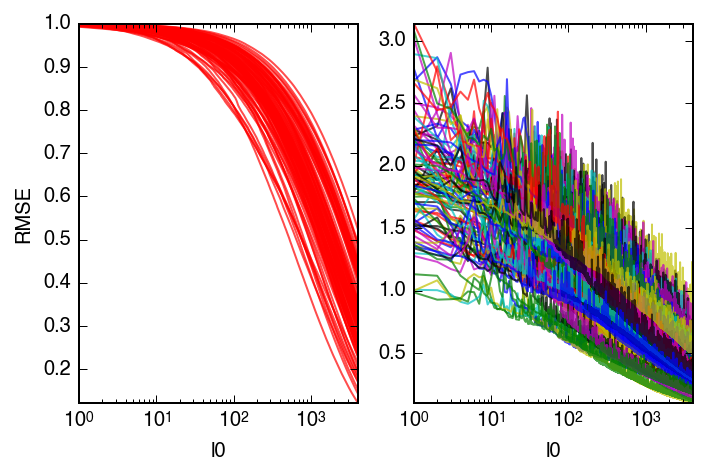

In [21]:
fig, [A, B] = plt.subplots(1, 2, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
A.set_color_cycle(np.array([[1., 0., 0.]]))
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
RMSE /= RMSE[:, 0][:, np.newaxis]
#print( RMSE.shape, edgeslist.shape)
value = edgeslist[4, ...]
#value /= value[0, :][np.newaxis, :]
value /= RMSE[:, 0][np.newaxis, :]

B.semilogx( value, alpha=.7)

A.semilogx( RMSE.T, alpha=.7)
A.set_xlabel('l0')
B.set_xlabel('l0')
A.axis('tight')
B.axis('tight')
_ = A.set_ylabel('RMSE')


#plt.locator_params(axis = 'x', nbins = 5)
#plt.locator_params(axis = 'y', nbins = 5)

fig.savefig(os.path.join(figpath, exp + '_raw' + ext))

In [22]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment + '_linear', name_database=name_database)
RMSE /= RMSE[:, 0][:, np.newaxis]
print(RMSE, RMSE.shape, edgeslist.shape)


[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]] (100, 4096) (6, 4096, 100)


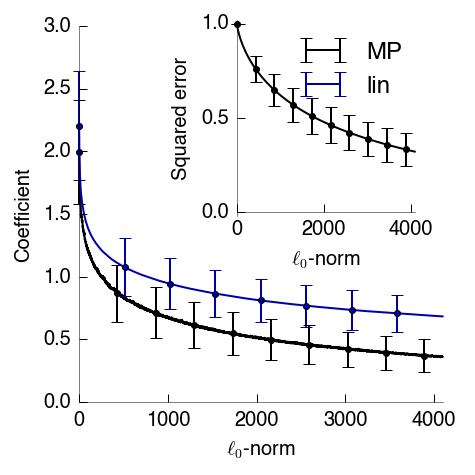

In [23]:
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, ax, inset = mp.plot(mps=mps, experiments=[experiment, experiment + '_linear'], databases=[name_database, name_database], fig=fig, 
                  color=[0., 0., 1.], scale=False, labels=['MP', 'lin'])

fig.savefig(os.path.join(figpath, exp + '_raw_inset' + ext))

## trying different fits

### on the modulation function
!pip install lmfit

In [24]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
value = edgeslist[4, ...].T
#value /= RMSE[:, 0][np.newaxis, :]
value /= RMSE[:, 0][:, np.newaxis]
#RMSE /= RMSE[:, 0][:, np.newaxis]
N_image, N = RMSE.shape #number of images x edges
#value = value.T

In [25]:
from lmfit.models import ExpressionModel
mod = ExpressionModel('amplitude * exp ( - .5 * log(x+1)**2 / log(rho+1) **2 )')
verbose = False
amplitude, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'amplitude':.01, 'rho':100}
    params = mod.make_params()
    out  = mod.fit(value[i_image, :], x=np.arange(N), verbose=verbose)
    #print(out.fit_report())
    amplitude[i_image] = out.params.get('amplitude').value
    rho[i_image] =  out.params.get('rho').value

In [26]:
amplitude, rho

(array([ 0.01,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.01,  0.01,
         0.  ,  0.01,  0.  ,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,
         0.  ,  0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.  ,
         0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.01,  0.  ,  0.  ,  0.01,  0.  ,  0.01,  0.  ,  0.01,  0.  ,
         0.  ,  0.  ,  0.01,  0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,
         0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.01,  0.02,
         0.  ,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,
         0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.01]),
 array([  42.82,   99.71,  131.37,   97.71,   76.18,  133.17,  135.14,
          61.31,   96.04,  266.26,   90.74,  153.57,   94.49,   65.76,
          75.4 ,  103.59,   89.07,   94.07,   87.37,   43.85,  140.4

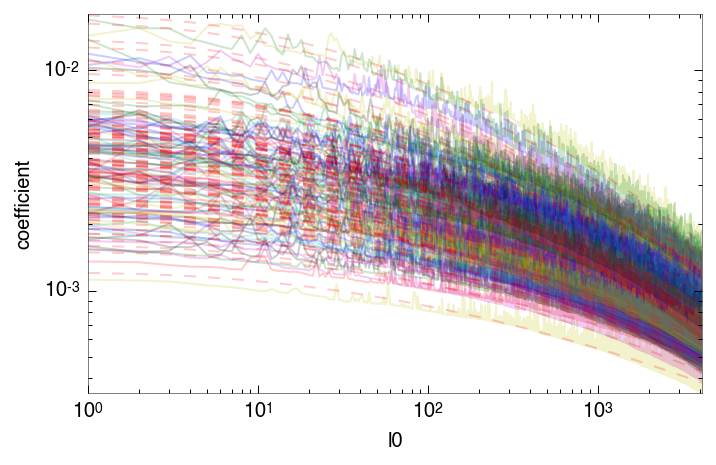

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.loglog( value[i_image, :], alpha=.2)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    ax.loglog(mod.eval(params, x=np.arange(N)), 'r--', alpha=.2)
    ax.set_xlabel('l0')
    ax.axis('tight')
    _ = ax.set_ylabel('coefficient')            
fig.savefig(os.path.join(figpath, exp + '_fit_all' + ext))

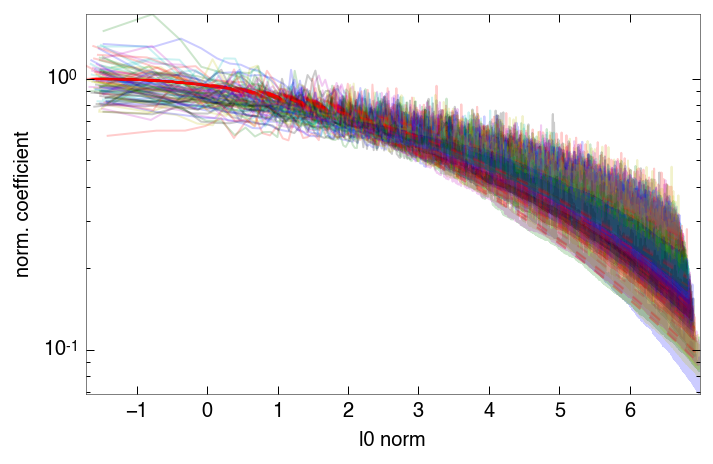

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.semilogy(np.log((np.arange(N)+1)/np.log(rho[i_image]+1)), value[i_image, :]/amplitude[i_image], alpha=.2)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    ax.semilogy(np.log((np.arange(N)+1)/np.log(rho[i_image]+1)), mod.eval(params, x=np.arange(N))/amplitude[i_image], 'r--', alpha=.2)
    ax.set_xlabel('l0 norm')
    ax.axis('tight')
    _ = ax.set_ylabel('norm. coefficient')            
fig.savefig(os.path.join(figpath, exp + '_fit_norm' + ext))

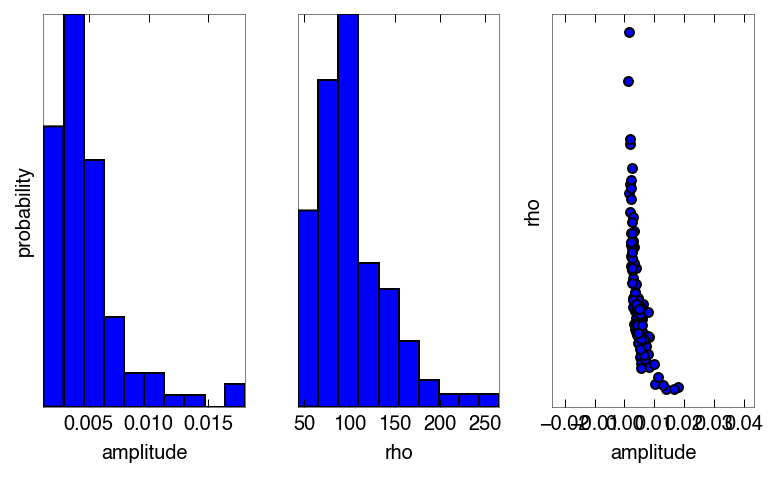

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

axs[0].hist(amplitude)
axs[1].hist(np.abs(rho))
axs[2].scatter(amplitude, np.abs(rho))
for ax in axs: 
    ax.axis('tight')
    _ = ax.set_ylabel('')            
    _ = ax.set_yticks([])            
axs[0].set_ylabel('probability')            
axs[0].set_xlabel('amplitude')
axs[1].set_xlabel('rho')
axs[2].set_xlabel('amplitude')
axs[2].set_ylabel('rho')
fig.tight_layout()
fig.savefig(os.path.join(figpath, exp + '_fit_hist' + ext))

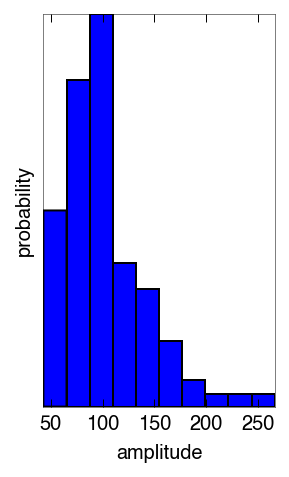

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width/2.618, fig_width/1.618), subplot_kw={'axisbg':'w'})

axs.hist(np.abs(rho))
axs.axis('tight')
_ = axs.set_ylabel('')            
_ = axs.set_yticks([])            
axs.set_ylabel('probability')            
axs.set_xlabel('amplitude')
fig.tight_layout()
fig.savefig(os.path.join(figpath, exp + '_fit_hist' + ext))


### on the pdf

In [31]:
help(np.histogram)

Help on function histogram in module numpy.lib.function_base:

histogram(a, bins=10, range=None, normed=False, weights=None, density=None)
    Compute the histogram of a set of data.
    
    Parameters
    ----------
    a : array_like
        Input data. The histogram is computed over the flattened array.
    bins : int or sequence of scalars or str, optional
        If `bins` is an int, it defines the number of equal-width
        bins in the given range (10, by default). If `bins` is a
        sequence, it defines the bin edges, including the rightmost
        edge, allowing for non-uniform bin widths.
    
        .. versionadded:: 1.11.0
    
        If `bins` is a string from the list below, `histogram` will use
        the method chosen to calculate the optimal bin width and
        consequently the number of bins (see `Notes` for more detail on
        the estimators) from the data that falls within the requested
        range. While the bin width will be optimal for the actua

In [32]:
value.max(axis=1).shape

(100,)

In [33]:
%pwd


'/Users/laurentperrinet/pool/science/BICV/SparseEdges/test'

In [34]:
#imagelist, edgeslist, RMSE = mp.process(exp=experiment + '_linear', name_database=name_database)
#imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
edgeslist = np.load('mat/edges/retina_sparseness_serre07_distractors_edges.npy')
value = edgeslist[4, ...].T
#value /= RMSE[:, 0][np.newaxis, :]
value /= value.min(axis=1)[:, np.newaxis]
#RMSE /= RMSE[:, 0][:, np.newaxis]
N_image, N = value.shape #number of images x edges
#value = value.T

In [35]:
N_bins, a_max = 128, value.max()
start, end = N_bins/16, N_bins
print(a_max)
v_hist = np.zeros((N_image, N_bins))
#bins = np.linspace(0, a_max, N_bins+1, endpoint=True)#[:-1]
#print(bins.shape)
for i_image in range(N_image):
    #v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=bins) 
    v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=N_bins) 
    v_hist[i_image, : ] /= v_hist[i_image, : ].sum()
print(v_bins.shape)
v_middle = .5*(v_bins[1:]+v_bins[:-1])

12.9868477695
(129,)


1.0 1.02124006989
6.4374578928 6.41621782291


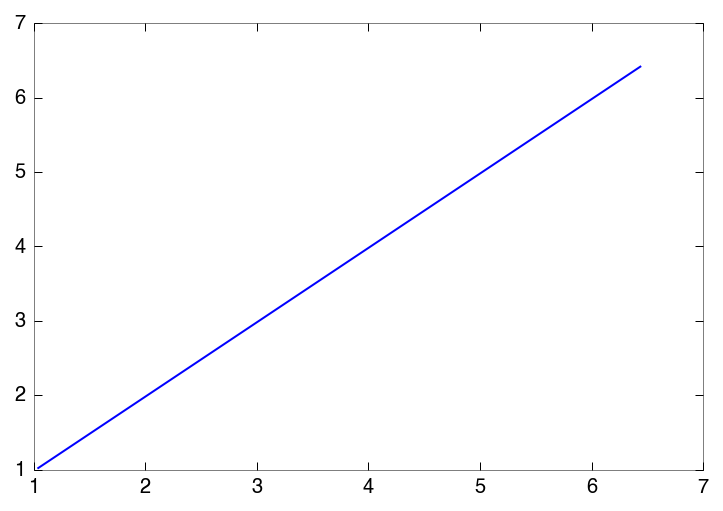

In [36]:
plt.plot(v_bins[1:], v_middle)
print(v_bins[0], v_middle[0])
print(v_bins[-1], v_middle[-1])

MLE estimate of rho:
https://en.wikipedia.org/wiki/Power_law#Maximum_likelihood


In [37]:
amplitude, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    rho[i_image] =  1 +  (end-start) / np.sum(np.log(value[i_image, start:end]))
    amplitude[i_image] = rho[i_image] - 1
print(rho)

[ 1.48  1.77  1.86  1.75  1.67  1.86  1.85  1.6   1.77  2.15  1.73  1.92
  1.73  1.63  1.72  1.77  1.71  1.73  1.71  1.52  1.86  1.84  2.01  1.9
  1.67  1.69  2.07  1.73  1.61  1.7   1.56  1.79  1.69  1.74  1.81  1.7
  1.66  1.82  1.98  1.7   1.75  1.6   1.86  1.7   1.73  1.81  1.94  1.65
  1.67  1.6   1.56  1.72  1.84  1.81  1.88  1.93  1.95  1.69  1.65  1.66
  1.69  1.53  1.67  1.72  1.75  1.83  1.72  1.73  1.53  1.61  1.63  1.52
  1.83  1.73  1.66  1.76  1.84  1.77  1.75  1.82  1.71  1.99  1.76  1.73
  1.72  1.73  1.92  1.95  1.53  1.85  1.73  1.9   1.77  1.59  1.74  1.68
  1.93  1.64  1.7   1.74]


In [38]:
from lmfit.models import ExpressionModel
mod = ExpressionModel('amplitude * x**-rho ')
#mod = ExpressionModel('amplitude * exp( - log(x)**2/rho**2 ) ')
#mod = ExpressionModel('amplitude * exp( - x/rho ) ')
verbose = False
for i_image in range(N_image):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'amplitude': amplitude[i_image], 'rho': rho[i_image]}
    params = mod.make_params()
    out  = mod.fit(v_hist[i_image, start:end], x=v_middle[start:end], verbose=verbose)
    #print(out.fit_report())
    amplitude[i_image] = out.params.get('amplitude').value
    rho[i_image] =  out.params.get('rho').value
print(rho)    

[ 3.2   3.    2.68  2.52  2.89  2.98  2.32  3.31  3.37  2.49  2.85  2.85
  3.01  3.02  4.29  2.68  2.83  2.92  2.86  3.37  2.41  2.7   2.3   3.2
  2.88  3.86  2.31  2.93  3.27  4.77  2.51  2.85  2.83  2.38  2.46  3.28
  3.11  3.05  2.93  2.66  2.79  2.97  2.9   2.52  2.47  3.8   2.67  3.19
  3.16  2.54  2.97  3.11  2.26  2.88  2.38  2.3   2.89  3.27  2.97  2.73
  3.52  3.74  2.62  2.7   2.77  2.8   3.41  3.02  3.17  3.7   3.43  4.05
  2.82  3.29  2.96  3.03  2.76  3.47  2.96  3.6   3.56  2.13  2.9   2.72
  2.62  3.21  3.16  2.69  3.83  2.9   2.44  2.66  3.31  3.7   3.12  2.94
  2.39  3.07  3.07  3.02]


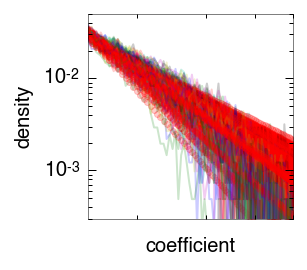

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width/3, fig_width/3), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.plot(v_middle, v_hist[i_image, :], alpha=.2)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    ax.plot(v_middle[start:end], mod.eval(params, x=v_middle[start:end]), 'r.', alpha=.2)
    if True:
      ax.set_yscale('log')
      ax.set_xscale('log')
    ax.axis('tight')
    ax.set_xlim(1.5, 5)
    ax.set_ylim(.0003, .05)
    ax.set_ylabel('density')
    ax.set_xlabel('coefficient')            
fig.savefig(os.path.join(figpath, exp + '_proba' + ext))

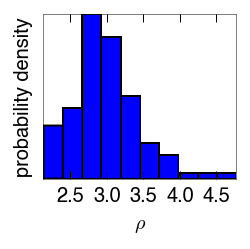

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width/3, fig_width/3), subplot_kw={'axisbg':'w'})

axs.hist(np.abs(rho))
axs.axis('tight')
_ = axs.set_ylabel('')            
_ = axs.set_yticks([])            
axs.set_ylabel('probability density')            
axs.set_xlabel(r'$\rho$')
fig.tight_layout()
fig.savefig(os.path.join(figpath, exp + '_fit_hist' + ext))

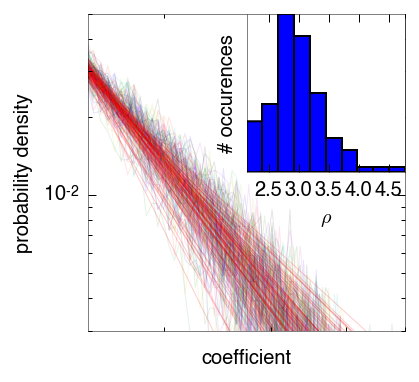

In [56]:
#fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_width/2), subplot_kw={'axisbg':'w'})
fig = plt.figure(figsize=(fig_width/2, fig_width/2))

ax = fig.add_axes([0.18, 0.15, .8, .8], axisbg='w')

for i_image in range(N_image):
    ax.plot(v_middle, v_hist[i_image, :], '-', alpha=.1, lw=.5)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    ax.plot(v_middle[start:end], mod.eval(params, x=v_middle[start:end]), 'r', alpha=.2, lw=.5)
    if True:
      ax.set_yscale('log')
      ax.set_xscale('log')
    ax.axis('tight')
    ax.set_xlim(1.5, 5.)
    ax.set_ylim(.003, .05)
    ax.set_ylabel('probability density')
    ax.set_xlabel('coefficient')  

inset = fig.add_axes([0.58, 0.55, .4, .4], axisbg='w')

inset.hist(np.abs(rho))
inset.axis('tight')
_ = inset.set_ylabel('')            
_ = inset.set_yticks([])            
inset.set_ylabel('# occurences')            
inset.set_xlabel(r'$\rho$')

#fig.subplots_adjust(left=0.22, bottom=0.1, right=.9, top=.9)

fig.savefig(os.path.join(figpath, exp + '_proba_inset' + ext))

In [42]:

rho_0 = rho.mean()
print(rho_0)
v_hist_scale = np.zeros((N_image, N_bins))
for i_image in range(N_image):
    #v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=bins) 
    v_hist_scale[i_image, : ], v_bins = np.histogram(value[i_image, :]**((rho_0-1)/(rho[i_image]-1)), bins=N_bins) 
    v_hist_scale[i_image, : ] /= v_hist_scale[i_image, : ].sum()
    


2.98177020238


In [43]:
amplitude_scale, rho_scale = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod.def_vals = {'amplitude': amplitude[i_image], 'rho': rho[i_image]}
    params = mod.make_params()
    out  = mod.fit(v_hist_scale[i_image, start:end], x=v_middle[start:end], verbose=verbose)
    amplitude_scale[i_image] = out.params.get('amplitude').value
    rho_scale[i_image] =  out.params.get('rho').value
print(rho_scale)    

[ 3.    2.99  3.02  2.99  2.97  2.99  2.96  3.03  3.2   2.91  2.97  2.95
  2.97  2.99  3.08  2.99  3.03  2.95  3.07  3.26  2.99  3.    2.92  3.09
  2.92  3.35  2.89  2.96  3.05  3.09  2.95  2.96  2.95  3.    3.    3.01
  2.94  2.98  3.    2.95  2.97  2.99  2.97  2.91  2.94  2.94  2.89  2.92
  3.05  2.88  2.99  3.03  2.92  2.91  2.93  2.9   2.98  3.03  2.96  2.89
  3.03  3.15  2.92  2.89  2.89  3.    3.06  2.98  2.95  2.97  3.07  3.15
  2.94  3.03  2.96  2.96  2.97  2.98  2.97  3.13  3.02  2.93  3.01  3.03
  2.95  3.05  3.01  2.86  2.96  3.01  2.86  2.88  3.02  3.16  2.96  3.01
  2.95  3.    3.05  3.02]


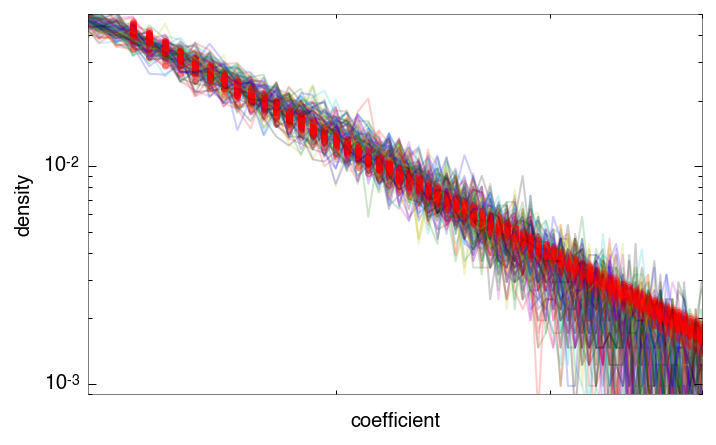

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.plot(v_middle, v_hist_scale[i_image, :], alpha=.2)
    params = mod.make_params(amplitude=amplitude_scale[i_image], rho=rho_scale[i_image])
    ax.plot(v_middle[start:end], mod.eval(params, x=v_middle[start:end]), 'r.', alpha=.2)
    if True:
      ax.set_yscale('log')
      ax.set_xscale('log')
    ax.set_xlim(1.25, 4)
    ax.set_ylim(.0009, .05)
    ax.set_ylabel('density')
    ax.set_xlabel('coefficient')            
fig.savefig(os.path.join(figpath, exp + '_proba_scaled' + ext))


(array([ 10.,  26.,  34.,  17.,   6.,   2.,   2.,   1.,   1.,   1.]),
 array([ 2.86,  2.91,  2.96,  3.01,  3.06,  3.11,  3.15,  3.2 ,  3.25,
         3.3 ,  3.35]),
 <a list of 10 Patch objects>)

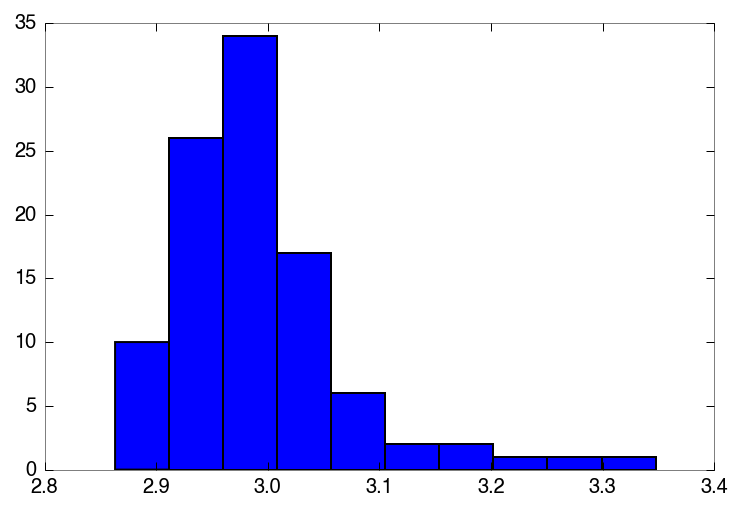

In [45]:
plt.hist(rho_scale)

## some book keeping for the notebook

In [46]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
20/05/2016 14:17:59

CPython 3.5.1
IPython 4.2.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)
system     : Darwin
release    : 15.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [47]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
IPython 4.2.0
OS Darwin 15.4.0 x86_64 i386 64bit
numpy 1.11.0
scipy 0.17.0
matplotlib 1.5.1
sympy 1.0
Fri May 20 14:18:00 2016 CEST